In [1]:
## I have a particular vision in mind

## I'm sick of the UK geographical map
## it's a fucking nightmare trying to read anything on
## something that makes such poor and confusing use of space

## So how about
## (i) take all the const level demographic variables
## (ii) Filter out some subset of 'better' ones (more 'political' ones)
## (iii) use PCA/Factor Analysis to reduce to X dimensions (~10ish)
## (iv) use umap/tsne to project down onto a 2d manifold (/take top 2 dim)
## (v) use hyperopt to set the parameters of the projections
## (vi) such that politically distinct const clusters are separable
## (vii) (some dumb/kmeans supervised clustering alg?)
## (viii)then maybe keep the structure but spread the points out evenly onto a square/rectangle
## (ix) and give each it's own space, voronoi-style -> stained glass window
## profit!

In [2]:
dataset_name = "W14_comb"
df_list = 'BES_Panel'
#            'BES_reduced_with_na'
#           ]#,"BESnumeric"]

%matplotlib inline 
%run BES_header.py {dataset_name} {df_list}

del BES_Panel

Toggle code

In [3]:
BES_census_data_2019 = pd.read_stata( BES_small_data_files + "BES-2019-General-Election-results-file-v1.0.dta" )
print("BES_census_data 2019", BES_census_data_2019.shape )

BES_census_data_2017 = pd.read_stata( BES_small_data_files + "BES-2017-General-Election-results-file-v1.0.dta" )
print("BES_census_data", BES_census_data_2017.shape )

BES_census_data_2015 = pd.read_stata( BES_small_data_files + "BES-2015-General-Election-results-file-v2.21.dta" )
print("BES_census_data 2015", BES_census_data_2015.shape )

BES_census_data = BES_census_data_2019.copy()

#### BUG! -> check if in latest release, if yes, then tell them! ###########
BES_census_data.loc[BES_census_data["Country"].isin(["Scotland"]),"c11Households"] =\
    BES_census_data.loc[BES_census_data["Country"].isin(["Scotland"]),"c11Households"]*100
BES_census_data["ConstituencyName"] = BES_census_data["ConstituencyName"].replace("Ynys Môn","Ynys Mon")
BES_census_data["Winner15"] = BES_census_data["Winner15"].replace("Speaker.","Speaker")

BES_census_data[search(BES_census_data_2015,"SpendPercent").index] = BES_census_data_2015[search(BES_census_data_2015,"SpendPercent").index]

BES_census_data[['SNPLongSpendPercent', 'SNPShortSpendPercent',
       'PCLongSpendPercent', 'PCShortSpendPercent']] = BES_census_data[['SNPLongSpendPercent', 'SNPShortSpendPercent',
       'PCLongSpendPercent', 'PCShortSpendPercent']].replace(".",np.nan).astype('float')

BES_census_data 2019 (632, 385)
BES_census_data (632, 308)
BES_census_data 2015 (632, 277)


In [4]:
party_19_list = search(BES_census_data,"^(Con|Lab|Brexit|LD|UKIP|SNP|PC|Green)19$").index
BES_census_data[[x+"_elec" for x in party_19_list]] = BES_census_data[party_19_list].apply(lambda x: x*BES_census_data["Turnout19"]/100).fillna(0)
BES_census_data["DNV19_elec"] = 100-BES_census_data["Turnout19"]
BES_census_data["DNV&OTH19_elec"] = 100-BES_census_data["Turnout19"]-BES_census_data["Other19"].fillna(0)
BES_census_data["Auth_Right19_elec"] = BES_census_data["Con19_elec"]+BES_census_data["UKIP19_elec"]+BES_census_data["Brexit19_elec"]
BES_census_data["Lib_Left19_elec"] = BES_census_data["Lab19_elec"]+BES_census_data["LD19_elec"]+BES_census_data["PC19_elec"]+BES_census_data["SNP19_elec"]+BES_census_data["Green19_elec"]

party_17_list = search(BES_census_data,"^(Con|Lab|Brexit|LD|UKIP|SNP|PC|Green)17$").index
BES_census_data[[x+"_elec" for x in party_17_list]] = BES_census_data[party_17_list].apply(lambda x: x*BES_census_data["Turnout17"]/100).fillna(0)
BES_census_data["DNV17_elec"] = 100-BES_census_data["Turnout17"]
BES_census_data["DNV&OTH17_elec"] = 100-BES_census_data["Turnout17"]-BES_census_data["Other17"].fillna(0)
BES_census_data["Auth_Right17_elec"] = BES_census_data["Con17_elec"]+BES_census_data["UKIP17_elec"]#+BES_census_data["Brexit17_elec"]
BES_census_data["Lib_Left17_elec"] = BES_census_data["Lab17_elec"]+BES_census_data["LD17_elec"]+BES_census_data["PC17_elec"]\
                                    +BES_census_data["SNP17_elec"]+BES_census_data["Green17_elec"]

party_15_list = search(BES_census_data,"^(Con|Lab|Brexit|LD|UKIP|SNP|PC|Green)15$").index
BES_census_data[[x+"_elec" for x in party_15_list]] = BES_census_data[party_15_list]\
                                    .apply(lambda x: x*BES_census_data["Turnout15"]/100).fillna(0)
BES_census_data["DNV15_elec"] = 100-BES_census_data["Turnout15"]
BES_census_data["DNV&OTH15_elec"] = 100-BES_census_data["Turnout15"]-BES_census_data["Other15"].fillna(0)
BES_census_data["Auth_Right15_elec"] = BES_census_data["Con15_elec"]+BES_census_data["UKIP15_elec"]#+BES_census_data["Brexit17_elec"]
BES_census_data["Lib_Left15_elec"] = BES_census_data["Lab15_elec"]+BES_census_data["LD15_elec"]+BES_census_data["PC15_elec"]\
                                    +BES_census_data["SNP15_elec"]+BES_census_data["Green15_elec"]

party_10_list = search(BES_census_data,"^(Con|Lab|BNP|LD|UKIP|SNP|PC|Green)10$").index
BES_census_data[[x+"_elec" for x in party_10_list]] = BES_census_data[party_10_list].apply(lambda x: x*BES_census_data["Turnout10"]/100).fillna(0)
BES_census_data["DNV10_elec"] = 100-BES_census_data["Turnout10"]
BES_census_data["DNV&OTH10_elec"] = 100-(BES_census_data[party_10_list].apply(lambda x: x*BES_census_data["Turnout10"]/100).sum(axis=1))
BES_census_data["Auth_Right10_elec"] = BES_census_data["Con10_elec"]+BES_census_data["UKIP10_elec"]+BES_census_data["BNP10_elec"]
BES_census_data["Lib_Left10_elec"] = BES_census_data["Lab10_elec"]+BES_census_data["LD10_elec"]+BES_census_data["PC10_elec"]\
                                    +BES_census_data["SNP10_elec"]+BES_census_data["Green10_elec"]

party_05_list = search(BES_census_data,"^(Con|Lab|BNP|LD|UKIP|SNP|PC|Green)05$").index
BES_census_data[[x+"_elec" for x in party_05_list]] = BES_census_data[party_05_list].apply(lambda x: x*BES_census_data["Turnout05"]/100).fillna(0)
BES_census_data["DNV05_elec"] = 100-BES_census_data["Turnout05"]
BES_census_data["DNV&OTH05_elec"] = 100-BES_census_data["Turnout05"]-BES_census_data["Other05"].fillna(0)
BES_census_data["Auth_Right05_elec"] = BES_census_data["Con05_elec"]+BES_census_data["UKIP05_elec"]+BES_census_data["BNP05_elec"]
BES_census_data["Lib_Left05_elec"] = BES_census_data["Lab05_elec"]+BES_census_data["LD05_elec"]+BES_census_data["PC05_elec"]\
                                    +BES_census_data["SNP05_elec"]+BES_census_data["Green05_elec"]


In [5]:
welsh_df = pd.read_excel( open(BES_small_data_files+'welsh_constituency_data.xls','rb'), sheet_name='WelshLanguage' )
welsh_df.columns = welsh_df.loc[4]
welsh_df = welsh_df.drop([0,1,2,3,4,50,51,52])
welsh_df = welsh_df.replace("Ynys Môn","Ynys Mon")
welsh_df = welsh_df.set_index("Assembly Constituency Area")
BES_census_data["speakWelsh"] = [welsh_df.loc[x,"Percentage aged 3+ who can speak Welsh"] if x in welsh_df.index else 0 for x in BES_census_data["ConstituencyName"]  ]

occ_df = pd.read_excel( open(BES_small_data_files+'Census2011-ConstituencyProfile-uk.xlsx','rb'), sheet_name='KS608D' )
occ_df.columns = occ_df.loc[3]
occ_df = occ_df.drop([0,1,2,3,654,])
# occ_df

var_list = ["CON%ELEM","CON%OPS","CON%SAL_SERV","CON%CAR_LEI_","CON%SKILL","CON%ADMIN_SEC","CON%ASSOC_PROF_TECH",
 "CON%PROF","CON%MAN_DIR_SEN"]

# occ_df = occ_df.set_index("ONSConstID").loc[merged.index]
# var_list = ["CON%ELEM","CON%OPS","CON%SAL_SERV","CON%CAR_LEI_","CON%SKILL","CON%ADMIN_SEC","CON%ASSOC_PROF_TECH",
#  "CON%PROF","CON%MAN_DIR_SEN"]

BES_census_data[var_list] = occ_df.set_index("ONSConstID").loc[BES_census_data["ONSConstID"]][var_list].values

merseyside = ["Birkenhead","Bootle","Garston and Halewood","Knowsley",
             "Liverpool, Riverside","Liverpool, Walton","Liverpool, Wavertree","Liverpool, West Derby",
             "Sefton Central","Southport","St Helens North","St Helens South and Whiston",
             "Wallasey","Wirral South","Wirral West"]

BES_census_data["Merseyside"] = BES_census_data["ConstituencyName"].isin(merseyside).astype('float')

In [6]:
df = pd.read_csv(BES_small_data_files+"CentreForTowns"+os.sep+"pcon-classification-csv.csv")

# https://www.centrefortowns.org/our-towns
    
# Type	Definition	Number
# Villages (less than 5,000)	Places with less than 5,000 residents	5,568
# Communities (5-10k)	Places with between 5,000 and 10,000 residents	567
# Small towns (10k-30k)	Towns with between 10,000 and 30,000 residents	550
# Medium towns (30k – 75k)	Towns with between 30,000 and 75,000 residents	242
# Large towns (over 75k)	Towns with over 75,000 residents	102
# Core Cities	Core cities as defined by Pike et al (2016)	12

## doesn't seem so consisent - where is 'communities!'
replace_dict = {"Village or Smaller":"Village or smaller",}
df["classification"] = df["classification"].replace(replace_dict)
centre_for_towns = df.pivot(index='constituency_code', columns='classification', values='percent_of_constituency').fillna(0)
BES_census_data[centre_for_towns.columns] = centre_for_towns.loc[BES_census_data["ONSConstID"]].values

In [9]:
parl_con_aggs = pd.read_csv(BES_small_data_files+"parliamentary constituency data"+os.sep+"Lots of aggregated parliamentary data.csv")

parl_con_aggs = parl_con_aggs.set_index("ONSConstID").drop(['Unnamed: 0', 'pano',
 'RESULTS2019_OTHER', 'RESULTS2019_Registered Voters', 'YOUGOVMRP_DEC_Con', 'YOUGOVMRP_DEC_Lab', 'YOUGOVMRP_DEC_LD',
       'YOUGOVMRP_DEC_Brexit', 'YOUGOVMRP_DEC_Green', 'YOUGOVMRP_DEC_SNP',
       'YOUGOVMRP_DEC_PC', 'YOUGOVMRP_DEC_Other', 'YOUGOVMRP_NOV_Con',
       'YOUGOVMRP_NOV_Lab', 'YOUGOVMRP_NOV_LD', 'YOUGOVMRP_NOV_Brexit',
       'YOUGOVMRP_NOV_Green', 'YOUGOVMRP_NOV_SNP', 'YOUGOVMRP_NOV_PC',
       'YOUGOVMRP_NOV_Other', 'ConVote17', 'TotalVote17', 'RejectedVote17',
       'Electorate17', 'ConVote15', 'TotalVote15', 'RejectedVote15',
       'Electorate15', 'ConVote10', 'TotalVote10', 'Electorate10',
       'c11Population','RESULTS2019_CON', 'RESULTS2019_LAB',
       'RESULTS2019_LIBDEM', 'RESULTS2019_GRN', 'RESULTS2019_SNP',
       'RESULTS2019_PC', 'RESULTS2019_BXP', 'RESULTS2019_UKIP',
       'RESULTS2019_Turnout','Turn10'],axis=1).select_dtypes(['float64','int64'])
parl_con_aggs = parl_con_aggs.drop(set(parl_con_aggs.columns).intersection(set(BES_census_data.columns)),axis=1)
parl_con_aggs = parl_con_aggs.loc[BES_census_data["ONSConstID"]]

BES_census_data[parl_con_aggs.columns] = parl_con_aggs.values
BES_census_data.columns = [x.replace("<","LT") for x in BES_census_data.columns]

In [10]:
BES_constituency_aggregates = pd.read_csv(BES_small_data_files+"parliamentary constituency data"+os.sep+"BES_constituency_aggregates.csv")
BES_constituency_aggregates = BES_constituency_aggregates.set_index("ons_const_id").drop(["Unnamed: 0","constituency_name","pano"],axis=1).loc[BES_census_data["ONSConstID"]]
# (632, 6868)

## a lot - won't add before testing!
nomis_dump = pd.read_csv(BES_data_folder+"Nomis"+os.sep+"2011ONS_England&Wales_by_parlcon.csv")
nomis_dump = nomis_dump.set_index("Unnamed: 0").loc[BES_census_data["ONSConstID"][~BES_census_data["Country"].isin(["Scotland"])]]
## England&Wales

In [11]:
drop_cols = ['Winner17', 'Winner15', 'Winner10','pano',#category
            'ConVote17', 'TotalVote17', 'Electorate17', 'ConVote15', 'TotalVote15',
       'Electorate15', 'ConVote10', 'TotalVote10', 'Electorate10', #int
             'LabVote19', 'Electorate19','RejectedVote19','LabVote05',
              'Lab17', 'LD17', 'SNP17', 'PC17', 'UKIP17', 'Green17',
             'Con0510', 'Lab0510', 'LD0510', 'SNP0510', 'PC0510',
       'BNP0510', 'UKIP0510', 'Green0510',
             'Con19', 'Lab19', 'LD19', 'SNP19', 'PC19', 'UKIP19', 'Green19',
       'Brexit19', 'Other19', 'Majority19', 'Turnout19', 'TotalVote19',
       'Con1719', 'Lab1719', 'LD1719', 'SNP1719', 'PC1719', 'UKIP1719',
       'Green1719',
             'ConVote19', 'LDVote19', 'SNPVote19', 'PCVote19', 'UKIPVote19',
       'GreenVote19', 'BrexitVote19',
             'leaveHanretty', 'remainHanretty',
             'Con05', 'Lab05', 'LD05', 'SNP05', 'PC05', 'UKIP05',
       'Green05', 'BNP05', 'Other05', 'Majority05', 'Turnout05', 'ConVote05',
       'LDVote05', 'SNPVote05', 'PCVote05', 'UKIPVote05', 'GreenVote05',
       'BNPVote05',
             'Winner05', 'ConPPCsex19', 'LabPPCsex19',
       'LDPPCsex19', 'SNPPPCsex19', 'PCPPCsex19', 'UKIPPPCsex19',
       'GreenPPCsex19', 'BrexitPPCsex19',
             # 'Con17',
       'Other17', 'Majority17', 'Turnout17', 'LabVote17', 'LDVote17',
       'SNPVote17', 'PCVote17', 'UKIPVote17', 'GreenVote17', 'Con1517',
       'Lab1517', 'LD1517', 'SNP1517', 'PC1517', 'UKIP1517', 'Green1517',
       'Con15', 'Lab15', 'LD15', 'SNP15', 'PC15', 'UKIP15', 'Green15',
       'Other15', 'Majority15', 'Turnout15', 'LabVote15', 'LDVote15',
       'SNPVote15', 'PCVote15', 'UKIPVote15', 'GreenVote15', 'BNPVote15',
       'Con1015', 'Lab1015', 'LD1015', 'SNP1015', 'PC1015', 'UKIP1015',
       'Green1015', 'Con10', 'Lab10', 'LD10', 'SNP10', 'PC10', 'UKIP10',
       'Green10', 'BNP10', 'Majority10', 'LabVote10', 'LDVote10',
       'SNPVote10', 'PCVote10', 'UKIPVote10', 'GreenVote10', 'BNPVote10',## float
       'ONSConstID', 'ConstituencyName', 'SeatChange1517', 'SeatChange1015',
       'ConPPC17', 'LabPPC17', 'LDPPC17', 'SNPPPC17', 'PCPPC17', 'UKIPPPC17',
       'GreenPPC17', 'ConPPC15', 'LabPPC15', 'LDPPC15', 'SNPPPC15', 'PCPPC15',
       'UKIPPPC15', 'GreenPPC15',     # object
       'ONSConstID', 'ConstituencyName', 'SeatChange1719', 'SeatChange1517',
       'SeatChange1015', 'ConPPC19', 'LabPPC19', 'LDPPC19', 'SNPPPC19',
       'PCPPC19', 'UKIPPPC19', 'GreenPPC19', 'BrexitPPC19', 'ConPPC17',
       'LabPPC17', 'LDPPC17', 'SNPPPC17', 'PCPPC17', 'UKIPPPC17', 'GreenPPC17',
       'ConPPC15', 'LabPPC15', 'LDPPC15', 'SNPPPC15', 'PCPPC15', 'UKIPPPC15',
       'GreenPPC15',
             'ConLongSpendPercent',
       'ConShortSpendPercent', 'LabLongSpendPercent', 'LabShortSpendPercent',
       'LDLongSpendPercent', 'LDShortSpendPercent', 'SNPLongSpendPercent',
       'SNPShortSpendPercent', 'PCLongSpendPercent', 'PCShortSpendPercent',
       'UKIPLongSpendPercent', 'UKIPShortSpendPercent',
       'GreenLongSpendPercent', 'GreenShortSpendPercent',
             'FOCALDATAMRP_DEC_Conservative',
 'FOCALDATAMRP_DEC_Labour',
 'FOCALDATAMRP_DEC_Liberal Democrats',
 'FOCALDATAMRP_DEC_SNP',
 'FOCALDATAMRP_DEC_Other',
 'FOCALDATAMRP_DEC_Green',
 'FOCALDATAMRP_DEC_Brexit Party',
 'FOCALDATAMRP_DEC_Plaid Cymru',
        'Winner19',
             'POLCOMP_Ec-Left-Right', 'POLCOMP_Soc-Lib-Con',
             'Turnout10',
            ]+['Con19_elec', 'Lab19_elec',
       'LD19_elec', 'SNP19_elec', 'PC19_elec', 'UKIP19_elec', 'Green19_elec',
       'Brexit19_elec', 'DNV19_elec', 'DNV&OTH19_elec', 'Auth_Right19_elec',
       'Lib_Left19_elec', 'Con17_elec', 'Lab17_elec', 'LD17_elec',
       'SNP17_elec', 'PC17_elec', 'UKIP17_elec', 'Green17_elec', 'DNV17_elec',
       'DNV&OTH17_elec', 'Auth_Right17_elec', 'Lib_Left17_elec', 'Con15_elec',
       'Lab15_elec', 'LD15_elec', 'SNP15_elec', 'PC15_elec', 'UKIP15_elec',
       'Green15_elec', 'DNV15_elec', 'DNV&OTH15_elec', 'Auth_Right15_elec',
       'Lib_Left15_elec', 'Con10_elec', 'Lab10_elec', 'LD10_elec',
       'SNP10_elec', 'PC10_elec', 'UKIP10_elec', 'Green10_elec', 'BNP10_elec',
       'DNV10_elec', 'DNV&OTH10_elec', 'Auth_Right10_elec', 'Lib_Left10_elec',
       'Con05_elec', 'Lab05_elec', 'LD05_elec', 'SNP05_elec', 'PC05_elec',
       'UKIP05_elec', 'Green05_elec', 'BNP05_elec', 'DNV05_elec',
       'DNV&OTH05_elec', 'Auth_Right05_elec', 'Lib_Left05_elec']+['TotalVote19',
                                                                  'TotalVote17', 'TotalVote15', 'TotalVote10',
       'TotalVote05','CLOCKFACEREP_diversity', 'CLOCKFACEREP_security',
       'CLOCKFACEREP_fecundity', 'CLOCKFACEREP_diversity_flatter',
       'CLOCKFACEREP_security_flatter',
        'LL17_elec', 'G-L-L17_elec','G-L17_elec',
        "LL15_elec","LL10_elec","LL05_elec",
        "G-L15_elec","G-L10_elec","G-L05_elec",
        "Con17",
                                                ]

# 'c11Population'

# df_simp = pd.get_dummies(BES_census_data.drop(drop_cols,axis=1))

In [12]:
import pickle
def dim_red(df,n_components=None,red_type="Factor Analysis",show_first_x_comps=4,display_comp=True):

    Treatment = "Census Data Decomposition"
    output_folder = "E:\\BES_analysis_data\\output\\CensusDataDecomposition\\"
    output_subfolder = output_folder + Treatment + os.sep
    if not os.path.exists( output_subfolder ):
        os.makedirs( output_subfolder )

    decomp_index = df.index
    decomp_columns = df.columns
    clean_feature_set_std = StandardScaler().fit_transform(df.values)
    decomp_std = pd.DataFrame(   clean_feature_set_std,
                                 columns = decomp_columns,
                                 index   = decomp_index      )
    if n_components is None:
        n_components = decomp_std.shape[1]
    
    # n_components = 4
    # (svd_solver='full', n_components='mle',whiten=True)
    
    if red_type == "Factor Analysis":
        decomp = FactorAnalysis(svd_method = 'lapack',n_components = n_components) ## ~10s ,n_components=30 -> 1.5 hr
    elif red_type == "PCA":
        decomp = PCA(n_components = n_components,svd_solver='full')    
    decomp_method = str(decomp).split("(")[0] 
    X_r = decomp.fit_transform(decomp_std)
    
    n_components = min(n_components,X_r.shape[1])
    BES_decomp = pd.DataFrame(   X_r,
                                 columns = range(0,n_components),
                                 index   = decomp_index)

#     save = True # False => Load
#     if save & ( 'decomp' in globals() ): # SAVE    ##( 'decomp' not in globals() )
#         decomp_method = str(decomp).split("(")[0] 
#         subdir = output_subfolder + decomp_method
#         fname = subdir+ os.sep + decomp_method
    subdir = output_subfolder + decomp_method
    if display_comp:
        (BES_decomp, comp_labels, comp_dict) = display_components(n_components, decomp,
                                                              decomp_columns, BES_decomp, manifest=None, 
                                                              save_folder = subdir,  
                                                              show_first_x_comps= show_first_x_comps, show_histogram = False)    
        return (BES_decomp, comp_labels, comp_dict)
    else:
        return BES_decomp

In [13]:
# BES_census_data.drop(drop_cols,axis=1,errors='ignore')
df_simp = pd.get_dummies(BES_census_data.drop(drop_cols,axis=1,errors='ignore'))

In [21]:
df_simp = df_simp.fillna(df_simp.mean())

In [24]:
df_simp = df_simp.dropna(axis=1)

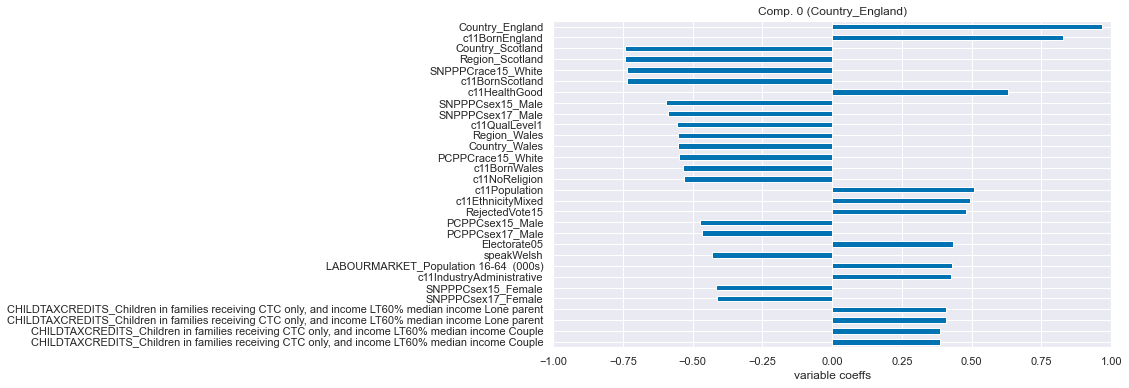

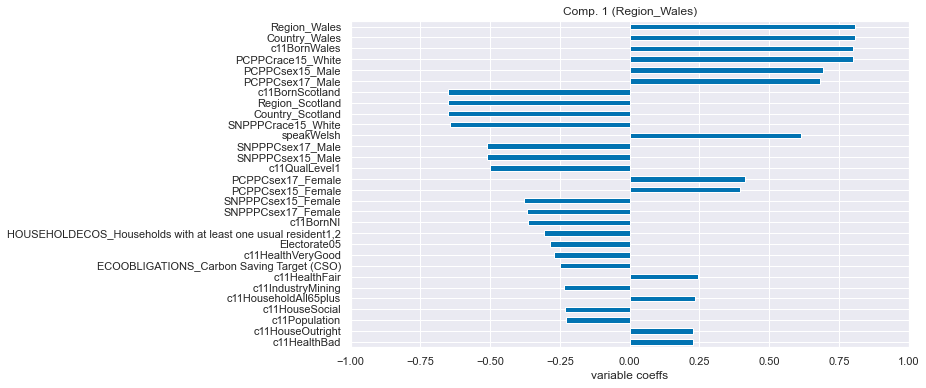

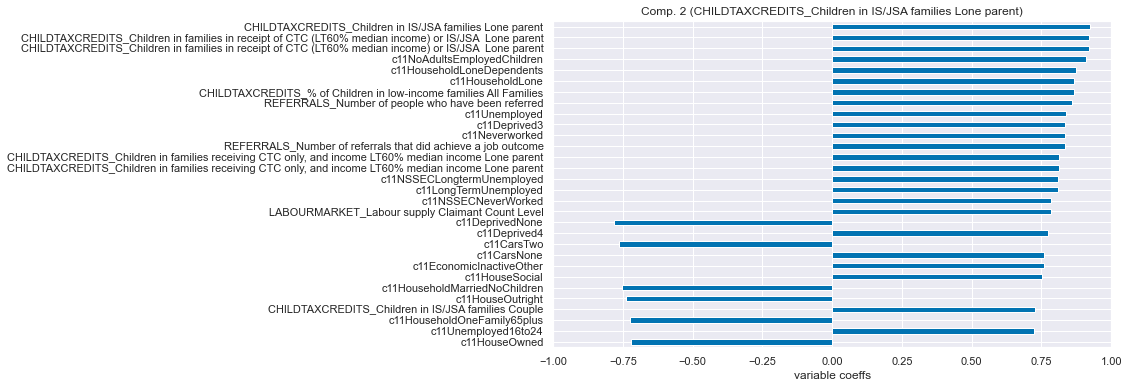

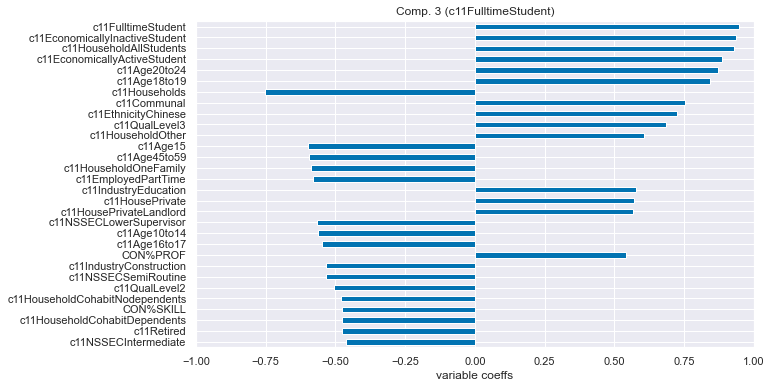

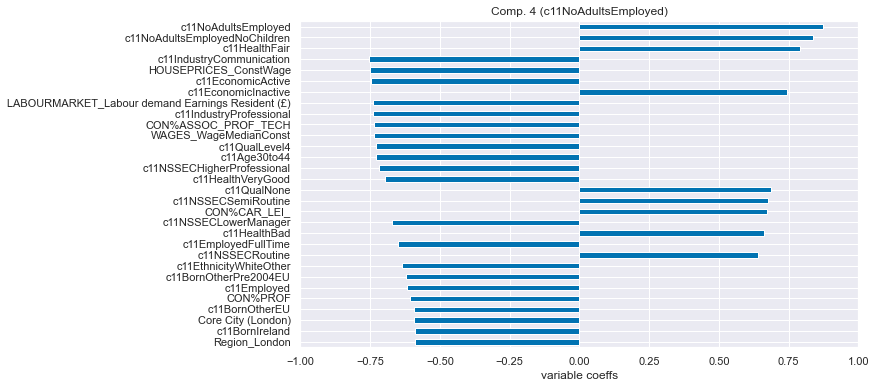

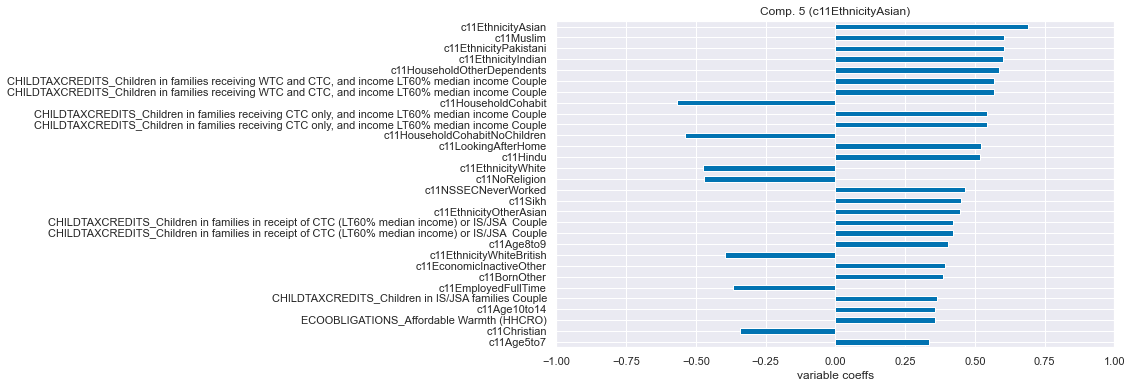

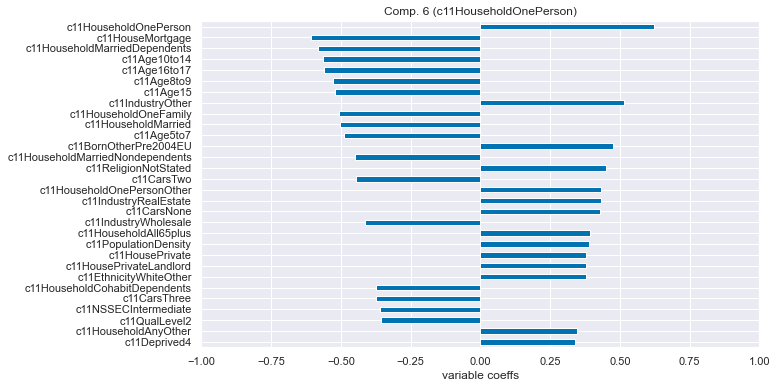

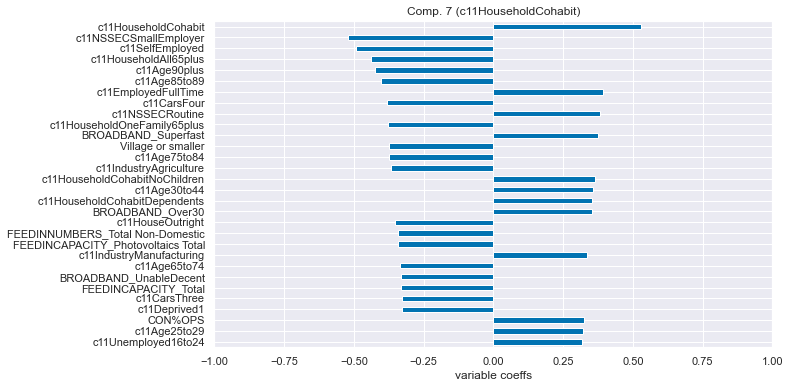

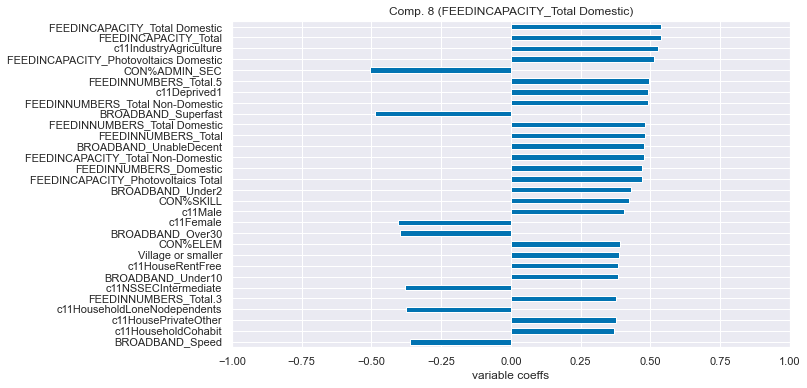

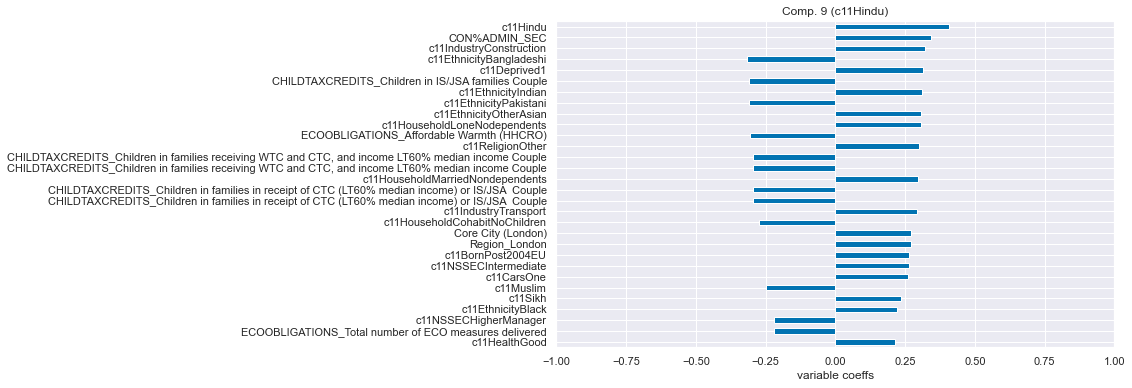

In [25]:
n_compFA = 10
n_comp = 10

(BES_decomp, comp_labels, comp_dict) = dim_red(df_simp, n_components=n_compFA,
                                               red_type="Factor Analysis",show_first_x_comps=n_comp)

In [26]:
import umap

In [27]:
palette = {'Conservative':"b", 'Labour':"r", 'Liberal Democrat':"orange", 'Plaid Cymru':"olive",
                  'Green':"g", 'Speaker':'grey', 'Scottish National Party':'y'}

Wall time: 7.05 s


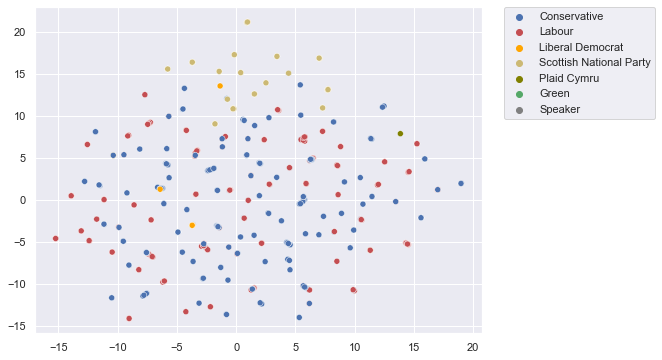

In [28]:
%%time
reducer = umap.UMAP(n_neighbors=2, # def 15
                    min_dist=.1,n_components=2,metric="euclidean")
embedding = reducer.fit_transform(BES_decomp.loc[:,0:n_comp])

plt.figure(figsize =(8,6));
sns.scatterplot(x=embedding[:,0],y=embedding[:,1],
                hue=BES_census_data["Winner19"].loc[BES_decomp.index],
                palette=palette)
# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [ ]:
# BES_census_data["Winner19"].cat.categories
# palette = {'Conservative':"b", 'Labour':"r", 'Liberal Democrat':"orange", 'Plaid Cymru':"olive",
#                   'Green':"g", 'Speaker':'grey', 'Scottish National Party':'y'}
# Create color maps


In [29]:
mask = (BES_census_data["Country"]=="England") & (BES_census_data["Winner19"].apply(lambda x: x not in ["Speaker","Green"]))

y = BES_census_data["Winner19"][mask].cat.codes
X = embedding[mask].copy()



from sklearn import neighbors, datasets

n_neighbors = 15
weights = "uniform"
# for weights in ["uniform", "distance"]:
    # we create an instance of Neighbours Classifier and fit the data.
    
clf = neighbors.KNeighborsClassifier(n_neighbors, weights=weights)
# clf.fit(X, y)
## can stratify so long as min sample size per category >= 2
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=42,stratify=y,
)    

clf.fit(X_train, y_train)
score = clf.score(X_test, y_test)

Wall time: 50.2 s


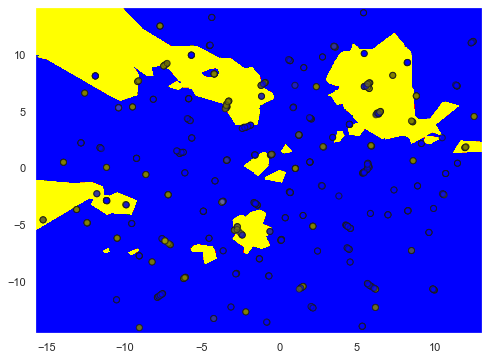

In [33]:
%%time
from matplotlib.colors import ListedColormap, BoundaryNorm
cmap_light = ListedColormap(["blue", "red", "orange","olive","green","grey","yellow"])
cmap_bold = ["blue", "red", "orange","olive","green","grey","yellow"]
from matplotlib.colors import ListedColormap
# ax = plt.subplot(1, 2,1)

h = 0.02  # step size in the mesh
cm = plt.cm.RdBu
cm_bright = ListedColormap(["#FF0000", "#0000FF"])

plt.figure(figsize=(8, 6))

x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))



Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, cmap=cmap_light)
ax = plt.gca()
ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cmap_light, edgecolors="k")
# Plot the testing points
ax.scatter(
    X_test[:, 0], X_test[:, 1], c=y_test, cmap=cmap_light, alpha=0.6, edgecolors="k"
)

# ax.set_xlim(xx.min(), xx.max())
# ax.set_ylim(yy.min(), yy.max())
# ax.set_xticks(())
# ax.set_yticks(())

In [34]:
score

0.647887323943662

In [35]:
y.value_counts()

0    345
1    179
2      7
dtype: int64

In [ ]:
# clf.fit(X_train, y_train)

In [ ]:
## Now, what was I doing here?

In [ ]:
# # %%time

# for pol_var in target_pol_var_list:
#     for year_combo in year_combo_list:
#         start = time.time()
#         print(pol_var,year_combo)

#         var_stub = "Voteshare"

#         var_set = [pol_var+x+"_elec" for x in year_combo]
#         df_simp = df_simp_base.loc[BES_census_data[var_set][geomask].reset_index().melt(id_vars='index')["index"]].copy()
#         temp = BES_census_data[var_set][geomask].melt(var_name="GE",value_name="Voteshare")
#         temp["GE"] = temp["GE"].astype('category')
#         temp = pd.get_dummies(temp)
#         df_simp[["Voteshare"]+year_combo] = temp.values
#         df_simp=df_simp.reset_index().drop("index",axis=1)   


#         # df_simp = pd.get_dummies(BES_census_data.drop(drop_cols+['Con17'],axis=1))[geomask]
#         # df_simp[var_stub] = BES_census_data[var_stub][geomask].values
#         threshold = 0.02
#         n_comp=2
#         n_compFA = 20


#         Treatment = var_stub

#         var_list = [var_stub]
#         var_stub_list = [var_stub,]
#         mask = df_simp[var_stub].notnull()
#         wt_cols = []
#         min_features = 30
#         colname = var_stub
#         dependence_plots = False

#         alg = get_xgboost_alg(classification_problem=False)
#         alg.colsample_bylevel = .545
#         alg.colsample_bytree = 0.43
#         alg.gamma = 7.0559722037762675
#         alg.learning_rate = 10**-1.0625
#         alg.max_depth = 5+2
#         alg.min_child_weight = 11.0
#         alg.subsample = 0.48

#         eval_metric=["rmsle"]

#         # alg.n_estimators=100
#         title = var_stub


#         (explainer, shap_values, train_columns, train_index, alg,output_subfolder)=\
#             xgboost_run(subdir=colname,dataset=df_simp[mask].drop(wt_cols,axis=1),
#                     var_list=var_list,var_stub_list=var_stub_list,
#                     use_specific_weights=None,
#                     min_features = min(df_simp.shape[1]-1,min_features),verbosity=0,
#                     skip_bar_plot=True,dependence_plots=dependence_plots,alg=alg,eval_metric=eval_metric,                    
#                     title = title,plot_validation=True)

#         dist = pd.DataFrame(shap_values).abs().mean(axis=0).sort_values(ascending=False)
#         print( train_columns[dist[dist>=threshold].index].shape,df_simp.shape )

#         space={ 
#             'threshold':hp.uniform('threshold', dist[dist>0].min(),dist.max()),
#             'n_comp_FA': hp.quniform('n_comp_FA', 0,20,1),
#             'n_comp': 2,
#           }        
#         trials = Trials()
#         best_hyperparams = fmin(fn = objective,
#                                 space = space,
#                                 algo = tpe.suggest,
#                                 max_evals = 100,
#                                 trials = trials)
#         print(best_hyperparams)
#         sns.lineplot(trials.vals['n_comp_FA'],trials.losses())
#         threshold = best_hyperparams['threshold']
#         n_comp_FA = best_hyperparams['n_comp_FA']
#         n_comp    = 2

#         df = df_simp[train_columns[dist[dist>=threshold].index]]
#         df = df.fillna(df.mean())
#         (BES_decomp, comp_labels, comp_dict) = dim_red(df, n_components=n_compFA,
#                                                        red_type="Factor Analysis",show_first_x_comps=n_comp)
#         Y = df_simp[var_stub]
#         X = BES_decomp.loc[:,0:(n_comp-1)]
#         X[year_combo[1:]] = df_simp[year_combo[1:]]
#         X = sm.add_constant(X)
#         model = sm.OLS(Y,X)
#         results = model.fit()
#         display(results.summary())
        
# #         results_store.loc[ind]
#         ind = results_store.index.max()
#         if pd.isnull(ind):
#             ind = 0
#         else:
#             ind = ind+1
#         end = time.time()
# #         print(end - start)            
#         results_store.loc[ind,["duration","n_comp","n_compFA","threshold",
#                             "variables",
#                             "results","BES_decomp"]] = [end-start,
#                                                                             n_comp,n_compFA,threshold,
#                                                                                                            df.columns,
#                                                                                                     results,BES_decomp]


In [ ]:
## tsne

Wall time: 343 ms


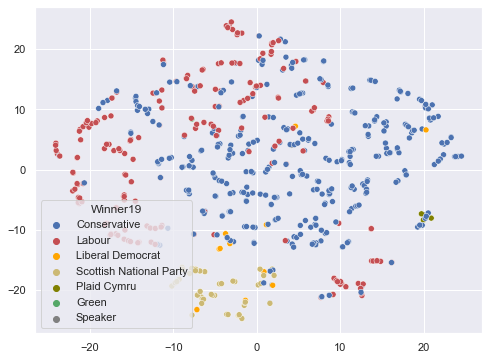

In [36]:
%%time
from sklearn import manifold, datasets
# perplexities = [5, 30, 50, 100]
perplexity = 5
n_components = 2
tsne = manifold.TSNE(
    n_components=n_components,
    init="random",
    random_state=0,
    perplexity=perplexity,
    learning_rate =100,
    n_iter=300,
)
Y = tsne.fit_transform(BES_decomp[[0, 1, 2, 4, 5, 6, 7, 8, ]])
palette = {'Conservative':"b", 'Labour':"r", 'Liberal Democrat':"orange", 'Plaid Cymru':"olive",
                  'Green':"g", 'Speaker':'grey', 'Scottish National Party':'y'}
plt.figure(figsize =(8,6));
sns.scatterplot(x=Y[:,0],y=Y[:,1],
                hue=BES_census_data["Winner19"].loc[BES_decomp.index],
                palette=palette)

In [37]:
import umap

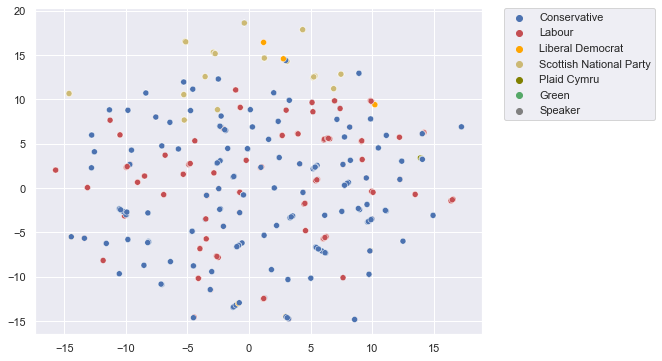

In [38]:
reducer = umap.UMAP(n_neighbors=2, # def 15
                    min_dist=.1,n_components=2,metric="euclidean")
embedding = reducer.fit_transform(BES_decomp[[0, 1, 2, 4, 5, 6, 7, 8, ]])

plt.figure(figsize =(8,6));
sns.scatterplot(x=embedding[:,0],y=embedding[:,1],
                hue=BES_census_data["Winner19"].loc[BES_decomp.index],
                palette=palette)
# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/10
12/12 [==============================] - 1s 5ms/step - loss: 1.2494
Epoch 2/10
12/12 [==============================] - 0s 4ms/step - loss: 0.4908
Epoch 3/10
12/12 [==============================] - 0s 4ms/step - loss: 0.3839
Epoch 4/10
12/12 [==============================] - 0s 4ms/step - loss: 0.3542
Epoch 5/10
12/12 [==============================] - 0s 4ms/step - loss: 0.3445
Epoch 6/10
12/12 [==============================] - 0s 4ms/step - loss: 0.3366
Epoch 7/10
12/12 [==============================] - 0s 4ms/step - loss: 0.3225
Epoch 8/10
12/12 [==============================] - 0s 4ms/step - loss: 0.3166
Epoch 9/10
12/12 [==============================] - 0s 4ms/step - loss: 0.3105
Epoch 10/10
12/12 [==============================] - 0s 4ms/step - loss: 0.3112


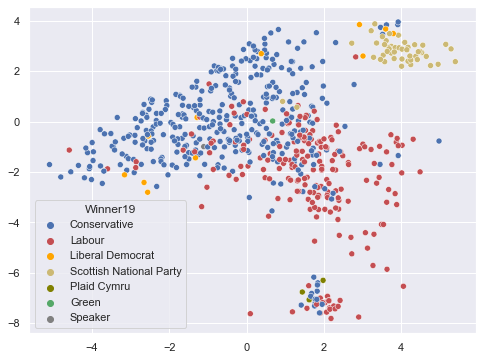

In [39]:
from umap.parametric_umap import ParametricUMAP
embedder = ParametricUMAP()
embedding = embedder.fit_transform(BES_decomp[[0, 1, 2, 4, 5, 6, 7, 8, ]])
plt.figure(figsize =(8,6));
sns.scatterplot(x=embedding[:,0],y=embedding[:,1],
                hue=BES_census_data["Winner19"].loc[BES_decomp.index],
                palette=palette)

In [ ]:
## drop speaker
## could make it easier to start with, look only at England
## could weight by majority

100%|██████████████████████████████████████████| 10000/10000 [35:26<00:00,  4.70trial/s, best loss: -0.863849765258216]
{'n_neighbours': 36.0, 'weights': 1}


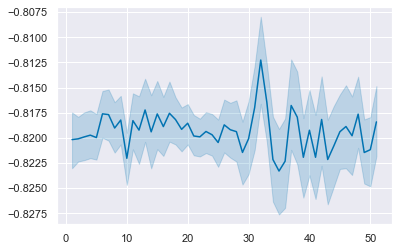

In [60]:
# %%time

from sklearn import neighbors, datasets
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
space={ 
#         'threshold':hp.uniform('threshold', dist[dist>0].min(),dist.max()),
#     #0.0243612172520986,
#     #
#         'n_comp_FA': hp.quniform('n_comp_FA', 0,20,1),
#     #hp.quniform('n_comp_FA', 1,2,1),
#         'n_comp': 2,
#     2hp.quniform('n_comp', 1,10,1),
    #2,
        'n_neighbours': hp.quniform('n_neighbours', 0,50,1),
        'weights':hp.choice('weights',[
                    {
                        'type':'uniform',
                    },
                    {
                        'type':'distance',
                    },] ),     

      }
def objective(space):
    
    n_neighbours = space['n_neighbours']+1
    weights = space['weights']['type']

    mask = (BES_census_data["Country"]=="England") & (BES_census_data["Winner19"].apply(lambda x: x not in ["Speaker","Green"]))

    y = BES_census_data["Winner19"][mask].cat.codes
    X = embedding[mask].copy()




#     n_neighbors = 15
#     weights = "uniform"
    # for weights in ["uniform", "distance"]:
        # we create an instance of Neighbours Classifier and fit the data.
        
    import random
    

    clf = neighbors.KNeighborsClassifier(n_neighbors, weights=weights)
    # clf.fit(X, y)
    ## can stratify so long as min sample size per category >= 2
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.4, random_state=random.randint(0,100),
        stratify=y,
    )    

    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    return {'loss': -score, 'status': STATUS_OK }


trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 10000,
                        trials = trials)
print(best_hyperparams)
sns.lineplot(np.array(trials.vals['n_neighbours'])+1,trials.losses())

7

In [168]:
# %%time

from sklearn import neighbors, datasets
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
space={ 
#         'threshold':hp.uniform('threshold', dist[dist>0].min(),dist.max()),
#     #0.0243612172520986,
#     #
#         'n_comp_FA': hp.quniform('n_comp_FA', 0,20,1),
#     #hp.quniform('n_comp_FA', 1,2,1),
#         'n_comp': 2,
#     2hp.quniform('n_comp', 1,10,1),
    #2,
        'n_neighbours': hp.quniform('n_neighbours', 0,125,1),
        'min_dist': hp.uniform('min_dist', 0.00,.99),
        'n_comp': hp.quniform('n_comp', 0,BES_decomp.shape[1]-3,1),
        'metric':hp.choice('metric',[
                    {
                        'type':'euclidean',
                    },
                    {
                        'type':'manhattan',
                    },
                    {
                        'type':'chebyshev',
                    },
                    {
                        'type':'minkowski',
                    },
                    {
                        'type':'canberra',
                    },
                    {
                        'type':'braycurtis',
                    },
#                     {
#                         'type':'haversine',
#                     }, # only 2d data
                    {
                        'type':'mahalanobis',
                    },
#                     {
#                         'type':'wminkowski',
#                     },
#                     {
#                         'type':'seuclidean',
#                     },
                    {
                        'type':'cosine',
                    },
                    {
                        'type':'correlation',
                    },
#                     {
#                         'type':'distance',
#                     },
#                     {
#                         'type':'distance',
#                     },
#                     {
#                         'type':'distance',
#                     },
#                     {
#                         'type':'distance',
#                     },
#                     {
#                         'type':'distance',
#                     },
#                     {
#                         'type':'distance',
#                     },
#                     {
#                         'type':'distance',
#                     },
#                     {
#                         'type':'distance',
#                     },
#                     {
#                         'type':'distance',
#                     },
#                     {
#                         'type':'distance',
#                     },
            
        
        ] ),     

      }
def objective(space):
    
    n_neighbours = space['n_neighbours']+2
    n_comp = space['n_comp']+2
    metric = space['metric']['type']
    min_dist = space['min_dist']

    mask = (BES_census_data["Country"]=="England") & (BES_census_data["Winner19"].apply(lambda x: x not in ["Speaker","Green"]))
    
    reducer = umap.UMAP(n_neighbors=int(n_neighbours), # def 15
                        min_dist=min_dist,
                        n_components=2,
                        metric=metric)
    embedding = reducer.fit_transform(BES_decomp.loc[:,0:n_comp][mask])

#     plt.figure(figsize =(8,6));
#     sns.scatterplot(x=embedding[:,0],y=embedding[:,1],
#                     hue=BES_census_data["Winner19"].loc[BES_decomp.index],
#                     palette=palette)
    # Put the legend out of the figure
#     plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)    
    

    y = BES_census_data["Winner19"][mask].cat.codes
    X = embedding.copy()




#     n_neighbors = 15
#     weights = "uniform"
    # for weights in ["uniform", "distance"]:
        # we create an instance of Neighbours Classifier and fit the data.
        
    import random
    

    clf = neighbors.KNeighborsClassifier(36, weights='distance')
    # clf.fit(X, y)
    ## can stratify so long as min sample size per category >= 2
    majority_weight = (BES_census_data["Majority19"][mask]+BES_census_data["Majority19"][mask].mean())/BES_census_data["Majority19"][mask].mean()
    majority_weight = (majority_weight/majority_weight.mean())
    X = pd.DataFrame(X)
    X["maj_wt"] = majority_weight.values

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.4, random_state=random.randint(0,100),
        stratify=y,
    )    

    maj_wt_test = X_test["maj_wt"].values
    X_test.drop("maj_wt",axis=1,inplace=True)
    X_test = X_test.values
    X_train.drop("maj_wt",axis=1,inplace=True)
    X_train = X_train.values

    clf.fit(X_train, y_train)



    score = clf.score(X_test, y_test, sample_weight=maj_wt_test)


#     clf.fit(X_train, y_train)
#     score = clf.score(X_test, y_test)
    return {'loss': -score, 'status': STATUS_OK }


trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 5000,
                        trials = trials)
print(best_hyperparams)
# sns.lineplot(np.array(trials.vals['n_neighbours'])+2,trials.losses())

100%|█████████████████████████████████████████| 5000/5000 [9:03:07<00:00,  6.52s/trial, best loss: -0.9331548327538016]
{'metric': 3, 'min_dist': 0.1866474677704782, 'n_comp': 6.0, 'n_neighbours': 106.0}


In [171]:
# best_hyperparams -> 9 hrs

# {'metric': 3, 'min_dist': 0.1866474677704782, 'n_comp': 6.0, 'n_neighbours': 106.0}



9.027777777777779

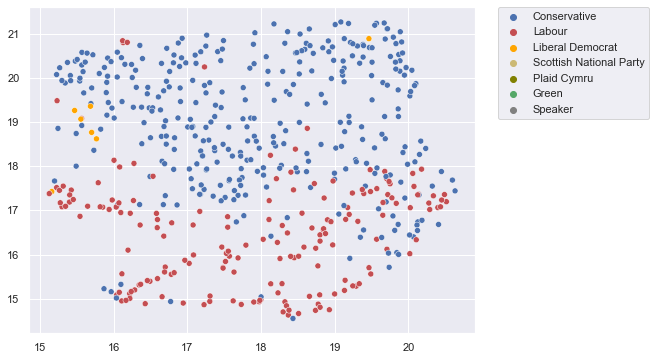

In [169]:
n_comp = best_hyperparams['n_comp']+2
mask = (BES_census_data["Country"]=="England") & (BES_census_data["Winner19"].apply(lambda x: x not in ["Speaker","Green"]))
metric = 'minkowski'
reducer = umap.UMAP(n_neighbors=int(best_hyperparams['n_neighbours']+2), # def 15
                    min_dist=best_hyperparams['min_dist'],
                    n_components=2,metric=metric)
embedding = reducer.fit_transform(BES_decomp.loc[:,0:n_comp][mask])

plt.figure(figsize =(8,6));
sns.scatterplot(x=embedding[:,0],y=embedding[:,1],
                hue=BES_census_data["Winner19"].loc[BES_decomp.loc[:,0:n_comp][mask].index],
                palette=palette)
# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

[]

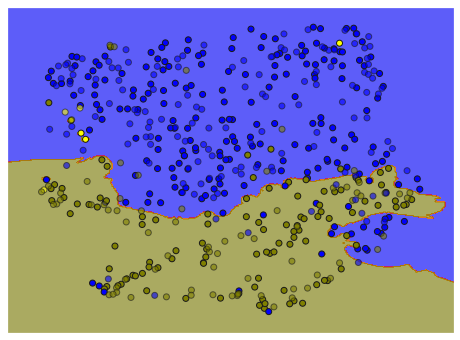

In [170]:
# %%time
from matplotlib.colors import ListedColormap, BoundaryNorm
cmap_light = ListedColormap(["blue", "red", "orange","olive","green","grey","yellow"])
cmap_bold = ["blue", "red", "orange","olive","green","grey","yellow"]
from matplotlib.colors import ListedColormap
# ax = plt.subplot(1, 2,1)

h = 0.02  # step size in the mesh
cm = plt.cm.RdBu
cm_bright = ListedColormap(["#FF0000", "#0000FF"])

plt.figure(figsize=(8, 6))

y = BES_census_data["Winner19"][mask].cat.codes
X = embedding.copy()

x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

clf = neighbors.KNeighborsClassifier(36, weights='distance')
# clf.fit(X, y)
## can stratify so long as min sample size per category >= 2
majority_weight = (BES_census_data["Majority19"][mask]+BES_census_data["Majority19"][mask].mean())/BES_census_data["Majority19"][mask].mean()
majority_weight = (majority_weight/majority_weight.mean())
X = pd.DataFrame(X)
X["maj_wt"] = majority_weight.values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=random.randint(0,100),
    stratify=y,
)    

maj_wt_test = X_test["maj_wt"].values
X_test.drop("maj_wt",axis=1,inplace=True)
X_test = X_test.values
X_train.drop("maj_wt",axis=1,inplace=True)
X_train = X_train.values

clf.fit(X_train, y_train)



score = clf.score(X_test, y_test, sample_weight=maj_wt_test)



Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, cmap=cmap_light,alpha=.6)
ax = plt.gca()
ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cmap_light, edgecolors="k")
# Plot the testing points
ax.scatter(
    X_test[:, 0], X_test[:, 1], c=y_test, cmap=cmap_light, alpha=0.6, edgecolors="k"
)

ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())
ax.set_xticks(())
ax.set_yticks(())

In [182]:
const_embedding = pd.DataFrame(embedding,index = BES_census_data["ConstituencyName"][mask])
const_embedding

,0,1
ConstituencyName,,
Aldershot,17.203869,18.230955
Aldridge-Brownhills,20.408915,16.680763
Altrincham and Sale West,15.411857,20.053585
Amber Valley,19.283648,18.146742
Arundel and South Downs,18.175447,21.221340
...,...,...
Wythenshawe and Sale East,18.287828,16.656755
Yeovil,18.954851,19.985432
York Central,16.071320,17.168800


In [197]:
n_neighbors = 1

edge_df = pd.DataFrame(columns=["Source","Destination","weight"])
edge_count = 0
for const in const_embedding.index:
    print(const)
    for targ_const in const_embedding.index:
        if const==targ_const:
            continue
        dist = np.sqrt( ((const_embedding.loc[const,0]-const_embedding.loc[targ_const,0])**2)+\
                ((const_embedding.loc[const,1]-const_embedding.loc[targ_const,1])**2) )
        if dist <= n_neighbors:
            edge_df.loc[edge_count] = [const,targ_const,
                                       n_neighbors/(n_neighbors+dist)]
            edge_count = edge_count+1
            

Aldershot
Aldridge-Brownhills
Altrincham and Sale West
Amber Valley
Arundel and South Downs
Ashfield
Ashford
Ashton-under-Lyne
Aylesbury
Banbury
Barking
Barnsley Central
Barnsley East
Barrow and Furness
Basildon and Billericay
South Basildon and East Thurrock
Basingstoke
Bassetlaw
Bath
Batley and Spen
Battersea
Beaconsfield
Beckenham
Bedford
Mid Bedfordshire
North East Bedfordshire
South West Bedfordshire
Bermondsey and Old Southwark
Berwick-upon-Tweed
Bethnal Green and Bow
Beverley and Holderness
Bexhill and Battle
Bexleyheath and Crayford
Birkenhead
Birmingham, Edgbaston
Birmingham, Erdington
Birmingham, Hall Green
Birmingham, Hodge Hill
Birmingham, Ladywood
Birmingham, Northfield
Birmingham, Perry Barr
Birmingham, Selly Oak
Birmingham, Yardley
Bishop Auckland
Blackburn
Blackley and Broughton
Blackpool North and Cleveleys
Blackpool South
Blaydon
Blyth Valley
Bognor Regis and Littlehampton
Bolsover
Bolton North East
Bolton South East
Bolton West
Bootle
Boston and Skegness
Bosworth
Bou

Workington
Worsley and Eccles South
East Worthing and Shoreham
Worthing West
The Wrekin
Wycombe
Wyre and Preston North
Wyre Forest
Wythenshawe and Sale East
Yeovil
York Central
York Outer
East Yorkshire


In [198]:
edge_df.shape[0]/const_embedding.shape[0]

46.47834274952919

In [255]:
import networkx as nx

In [217]:
# %%time
# nx.draw_spring(G,k=10,iterations=1000)

In [248]:
# const_embedding

In [319]:
# net.nodes

In [322]:
palette = {'Conservative':"b", 'Labour':"r", 'Liberal Democrat':"orange", 'Plaid Cymru':"olive",
                  'Green':"g", 'Speaker':'grey', 'Scottish National Party':'y'}

In [327]:
palette_explicit = {'Conservative':"blue", 'Labour':"red", 'Liberal Democrat':"orange", 'Plaid Cymru':"olive",
                  'Green':"green", 'Speaker':'grey', 'Scottish National Party':'yellow'}

In [363]:
compass_points = [(-1000,0),(-1000,0),
                  (0,1000),(0,1000),
                  (1000,0),(1000,0),
                  (0,-1000),(0,-1000)]
compass_points = (c for c in compass_points)

(1000, 0)

In [372]:
G = nx.from_pandas_edgelist(edge_df,source='Source',target='Destination')
from pyvis.network import Network
net = Network(notebook=True)
net.from_nx(G)

[item.update({'x':const_embedding.loc[item['id'],0].astype('float64'),
              'y':const_embedding.loc[item['id'],1].astype('float64'),
              'color':palette_explicit[ BES_census_data.set_index("ConstituencyName").loc[item['id'],"Winner19"] ],
              'mass': 100,
               'hidden':False,'physics':True,}) if item['id'] in const_embedding.index else item for item in net.nodes]

# compass = [(const_embedding[0]+const_embedding[1]).idxmax(),(const_embedding[0]+const_embedding[1]).idxmin(),(const_embedding[0]-const_embedding[1]).idxmax(),(const_embedding[0]-const_embedding[1]).idxmin()]

# [item.update({'physics':False,
#               'x':next(compass_points)[0],
#               'y':next(compass_points)[1]}) if item['id'] in compass else item for item in net.nodes]

# net.nodes[0]
# worked!

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [324]:
# const_embedding[0].astype('float16')

In [ ]:
## find 4 corner points and tag them physics = False

In [ ]:
## add a 'pseudobox' made of nodes
# - which are invisible
# - which don't move


# not clear if we can do this with

In [373]:
min_x = -1000
max_x = 1000
min_y = -1000
max_y = 1000

count = 0
hidden = False

# top edge
y_pos = max_y
for x_pos in np.linspace(min_x,max_x, 100 ):

    net.add_node(n_id = "box"+str(count),
                 hidden =hidden,physics=False,x=x_pos,y=y_pos)
    count = count+1
# bottom edge
y_pos = min_y
for x_pos in np.linspace(min_x,max_x, 100 ):
    net.add_node(n_id = "box"+str(count),
                 hidden =hidden,physics=False,x=x_pos,y=y_pos)
    count = count+1

# left edge
x_pos = min_x
for y_pos in np.linspace(min_y,max_y, 100 ):
    net.add_node(n_id = "box"+str(count),
                 hidden =hidden,physics=False,x=x_pos,y=y_pos)
    count = count+1

# right edge
x_pos = max_x
for y_pos in np.linspace(min_y,max_y, 100 ):
    net.add_node(n_id = "box"+str(count),
                 hidden =hidden,physics=False,x=x_pos,y=y_pos)
    count = count+1
    

In [374]:
net.show_buttons(filter_=['physics'])

In [376]:
# net.show('nx.html')